# JalluPredix - ML Module
### **Overview**
JalluPredix is an automatic system for real-time rainfall monitoring and prediction in Bolivia. It comprises two main parts: 

*   An IoT rain gauge built with Arduino and 3D printing
*   A webapp developed with MeanJS.

Since the device was initially meant to work in remote Bolivian towns and villages, the device has a GSM/GPRS component that sends the data every 24 hours. This collected data is processed with Python, Pandas, and Scikit-learn to make predictions using the ARIMA model for every weather station. 

Data from public rain gauges takes an important role as the project aims to provide accurate predictions correlating data from different sources. 

### **This file**
This notebook contains the code to clean both datasets (rainfall data from SENAMHI and rainfall data from JalluPredix IoT device). Then, it applies the ARiMA model to predict rainfall for the following days for every station. The project lets JalluPredix IoT devices become part of the network of public rain gauges currently deployed in Bolivia. 

### **TO-DO**
*   Implement **Kriging with External Drift** to obtain rainfall data from different places not covered by the public network of rain gauges. 
*   Use satellite data (CHIRPS satellite) to improve the accuracy of the predictor. 
*   Automate the scrapper to keep the local database updated when deployed. 
*   Implement an **RNN or LSTM** and contrast the results with updated data.
*   Develop a public interface to see historical data and predictions. The current interface is meant to be used by employees of the Ministry of Environment and Water of Bolivia. 

In [58]:
#!rm *.*

# Upload file with rainfall data provided by SENAMHI
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving list_downloaded.csv to list_downloaded.csv
User uploaded file "list_downloaded.csv" with length 19125 bytes


In [59]:
# Upload file with rainfall data from the IoT rain gauge 
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving list_raingauge.csv to list_raingauge.csv
User uploaded file "list_raingauge.csv" with length 2930 bytes



### Data cleaning 

In [61]:
# Data cleaning
import pandas as pd 
senamhi = pd.read_csv('list_downloaded.csv')
senamhi = pd.read_csv('list_downloaded.csv')

jallupredix = pd.read_csv('list_raingauge.csv')

def clean_data(val):
    if val == "*" or val == "0": 
      val = None
    # data = val.replace('*','0')
    return val

senamhi['precipitation'] = senamhi['precipitation'].apply(clean_data)
senamhi['precipitation'] = senamhi['precipitation'].astype('float64')

jallupredix['precipitation'] = jallupredix['precipitation'].apply(clean_data)
jallupredix['precipitation'] = jallupredix['precipitation'].astype('float64')

def diagnose_dataset(df):
    for i in df.columns:
        print(i+': '+str(df[i].isnull().sum()))

diagnose_dataset(senamhi)
diagnose_dataset(jallupredix)

station: 0
date: 0
precipitation: 496
station: 0
date: 0
precipitation: 0


It can be conlcluded that rainfall data provided by SENAMHI has many null values, so missing values will be filled using the dataframe.ffill() method, which propagates previous and later values for missing values. 

In [64]:
senamhi['precipitation'].fillna(method='ffill', limit=5,inplace=True)
senamhi['precipitation'].fillna(method='bfill', limit=5,inplace=True)
diagnose_dataset(senamhi)

station: 0
date: 0
precipitation: 0


Convert the categoric variable 'station' to numeric in both data sets. 

In [78]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

encoder = LabelEncoder()
senamhi["station_encoded"] = encoder.fit_transform(senamhi.station)

jallupredix["station"] = 18

is_camiri =  senamhi['station_encoded']==0
camiri = senamhi[is_camiri]

###Implement ARIMA Model to create predictions for every station

In [ ]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from sklearn.model_selection import train_test_split

dates = pd.date_range(start=camiri['date'].iloc[0], freq='D', periods=len(camiri))
camiri.set_index(dates,inplace=True)
print(camiri)
train = camiri[camiri.index < camiri['date'].iloc[30]]
test = camiri[camiri.index >= camiri['date'].iloc[30]]

model = ARMA(train['precipitation'],order=(2,0))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# plot results
plt.figure(figsize=(12,6))
plt.plot(test['precipitation'])
plt.plot(predictions, color='red')
plt.show()

### Visualize data from a station with predictions 

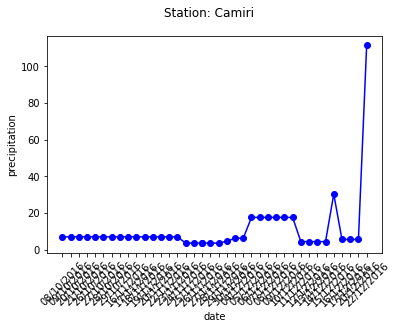

In [95]:
plt.plot(camiri['date'], camiri['precipitation'], '-ok', color='blue')
plt.suptitle('Station: Camiri')
plt.xlabel('date')
plt.ylabel('precipitation')
plt.xticks(rotation=45)
plt.show()